# Generating GKP states using optimized parameters

Given a file of gate parameters, this notebook runs a parameterized quantum circuit to prepare a state.

In [1]:
# Importing necessarry libraries
import strawberryfields as sf
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sf.hbar = 1 # Setting convention for hbar

In [ ]:
# Setting parameters:
cutoff=120 # Truncation of the Fock space
delta=0.12 # Inverse width of Gaussian envelope
epsilon=delta**2 # Strawberry Fields parameter epsilon, which defines the Gaussian envelope in sf.ops.GKP
bestSolution=np.loadtxt('OptParamsGKP0.out') # Load file containing optimized parameters
target=[0,0] # set the target state to match that of the OptParams file
# [0,0] for GKP 0 computational basis state
# [np.pi/2,-np.pi/4] for GKP H magic state

In [12]:
def prepare_state(params):
    """
    Return the quantum state resulting from the application of the parametrized circuit *in reverse* to the vacuum.

    Parameters:
    - params (array): An array of real numbers representing the parameters for the gates of the circuit.

    Returns:
    BaseFockState: The output quantum state, in the Fock basis.
    """
    progParamState = sf.Program(1) # Photonic circuit with one mode
    with progParamState.context as q: 
        sf.ops.Vacuum() | q # Initialize vacuum
        rev_pars = np.flip(params) # Reverse the order of the gate parameters
        for j in range(len(params)//4): # Circuit in reverse:
            sf.ops.Sgate(-rev_pars[4*j]/10.) | q 
            sf.ops.Kgate(-rev_pars[4*j+1]) | q
            sf.ops.Zgate(-rev_pars[4*j+2]) | q
            sf.ops.Xgate(-rev_pars[4*j+3]) | q
    
    # Initialize engine, selecting Fock backend
    eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff})

    # Output state of parametrized circuit
    prepared_state = eng.run(progParamState,shots=1).state 

    return prepared_state

# A program to prepare the target state, so that we can compare with our generated state
progTarget= sf.Program(1) # Photonic circuit with one mode
with progTarget.context as q: 
    # Initialize target state
    # NB this has to match the state used in the previous optimization
    sf.ops.GKP( epsilon=epsilon, state=target) | q 
    
eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff}) # Initialize engine, selecting Fock backend
target_GKP = eng.run(progTarget,shots=1).state.ket() # Our target state
#np.savetxt('TargetStateKet.out', target_GKP) # Save the Fock amplitudes of the target state
print(target_GKP)

[ 2.21928285e-01+5.02758378e-02j -1.34216632e-18-1.27795074e-18j
  7.55911940e-02+1.82493286e-01j -6.30189556e-18-5.52742644e-18j
  2.04814552e-01+4.63988770e-02j -3.47295996e-19+3.37772775e-18j
 -5.40374670e-02-1.30457986e-01j -5.03079260e-18+2.20127806e-19j
  3.84068654e-01+8.70072662e-02j -2.62873173e-18-4.58209683e-20j
  1.03241604e-02+2.49247280e-02j -6.37302902e-19+1.53036690e-18j
 -1.04022784e-01-2.35654172e-02j -7.49430584e-18-4.70716179e-18j
  7.94037632e-02+1.91697642e-01j -6.22329068e-18-5.38080392e-18j
  2.53676010e-01+5.74679967e-02j  5.58469667e-19+9.14425559e-19j
  4.82782467e-02+1.16553998e-01j -1.01528225e-18+3.17572627e-18j
 -3.92651267e-02-8.89515791e-03j -6.65793091e-18-7.66145964e-18j
 -5.90734234e-02-1.42615860e-01j -7.45610465e-19-1.22106018e-18j
  1.96676547e-01+4.45552858e-02j  3.08213365e-18+1.21694882e-18j
  3.68615949e-03+8.89917624e-03j -7.41615372e-19+3.16744992e-18j
  3.45879870e-01+7.83559439e-02j  4.17791960e-19+6.98181402e-19j
 -3.61820778e-02-8.735126

In [13]:
# Use best parameters to prepare generated state from vacuum
generated_GKP = prepare_state(bestSolution).ket()
#np.savetxt('GeneratedStateKet.out',generated_GKP)

# Calculate fidelity between generated state and target state
fid=np.abs(np.dot(generated_GKP.conj(), target_GKP))**2
print(f'Fidelity (abs squared overlap) with {len(bestSolution)//4} parametrized blocks: {fid}')

# Check normalization of target and generated state to ensure no leakage to Fock components higher than the cutoff
normgen=np.dot(generated_GKP.conj(), generated_GKP)
normtarg=np.dot(target_GKP.conj(), target_GKP)
print(f'This should be one if the state we prepared is normalized: {normgen}')
print(f'This should be one if the target GKP state is normalized: {normtarg}')

Fidelity (abs squared overlap) with 55 parametrized blocks: 0.9905579944932776
This should be one if the state we prepared is normalized: (0.9973025155972359-2.710505431213761e-20j)
This should be one if the target GKP state is normalized: (0.9999999999999993+1.3877787807814457e-17j)


### Wavefunction of target and generated states

We find the wavefunction in position, 
$$\Psi(q)=\left< q \,|\, \Psi_g \right>=\sum_n \left< q\,|\,n \right>\left< n\,|\,\Psi_g \right>,$$ 
from the Fock amplitudes of our generated state, $\left< n\,|\,\Psi_g \right>$. Here $\left< q \,|\, n \right>$ are Hermite functions,
$$\left< q \,|\, n \right> = \frac{e^{-\frac{1}{2}q^2}H_n(q)}{\sqrt{n!\,2^n\sqrt{\pi}}} ,$$
and $H_n(q)$ are Hermite polynomials.

We calculate $\frac{1}{\sqrt{2^n}}$ via recurrence relation:

In [14]:
def f(n):
    """
    Recursively calculates the value of f(n) = 1/sqrt(2**n).

    Parameters:
    - n (int): The input integer.

    Returns:
    float: The calculated value of f(n).
    """
    if n==0:
        return 1
    
    else:
        return (1/np.sqrt(2))*f(n-1)

We can also calculate $\sqrt{n!}$ recursively, by defining
$\\
g(n)=0 \;\; \text{for} \;\; n=0$  
$g(n)=\sum_n \ln(n) \;\; \text{for} \;\; 1\leq n \leq \mathrm{cutoff}$.

Then $\exp(g(n)/2)=\sqrt{n!}$ .

In [15]:
def g(n):
    """
    Recursively calculates the value of g(n)=ln(n!), so that exp(g(n)/2)=sqrt(n!).

    Parameters:
    - n (int): The input integer.

    Returns:
    float: The calculated value of g(n).
    """
    if n==0:    
        return 0
    
    else:
        return g(n-1)+np.log(n)

We can then calculate the wavefunction using $f(n)$ and $g(n)$:

In [16]:
def wavefunction(q, ket):
    """
    Compute the wavefunction in position space from the quantum state vector in the Fock basis.

    Parameters:
    - q (array): An array of position values.
    - ket (array): Fock-basis representation of the quantum state.

    Returns:
    array: Wavefunction in position basis.
    """
    c = ket.shape[0]
    coefficients=np.zeros(c,dtype=complex)

    # Calculating the coefficients (that depend on n) of each Hermite polynomial
    # i.e. coefficients[n] = <n|Psi_g>(n! 2**n)**(-1/2)
    for n in range(0,c):
        coefficients[n] = ket[n]*f(n)*np.exp(-g(n)/2)

    # Calculating the wavefunction, Psi(q):
    y = np.exp(-q ** 2 / 2)*np.pi**(-1/4) * np.polynomial.hermite.hermval(q, coefficients)
    
    return y

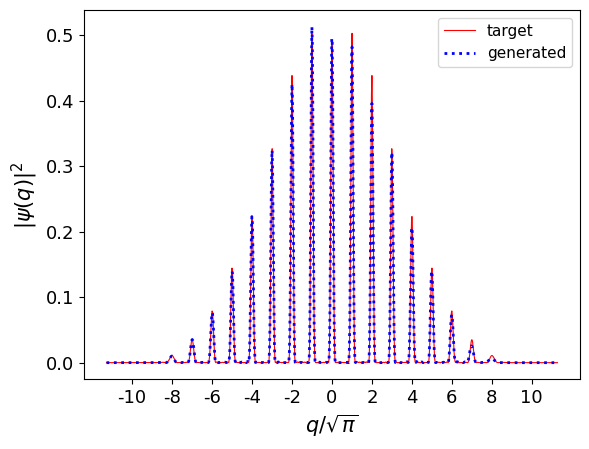

In [17]:
# Define sqrt(pi)
sqrt_pi = np.sqrt(np.pi)

# x values in q
q_vals = np.linspace(-20, 20, 1000)

# Convert to units of q / sqrt(pi)
x_units = q_vals / sqrt_pi

# Generate wavefunctions
genGKPwf = wavefunction(q=q_vals, ket=generated_GKP)
targetGKPwf = wavefunction(q=q_vals, ket=target_GKP)

# Plot using transformed x-axis
plt.plot(x_units, np.abs(targetGKPwf)**2, label='target', color='r', linewidth=0.8)
plt.plot(x_units, np.abs(genGKPwf)**2, label='generated', linestyle='dotted', color='b', linewidth=2)

# Axis labels and legend
plt.legend(fontsize=11)
plt.ylabel(r"$|\psi(q)|^2$", fontsize=15)
plt.xlabel(r"$q/\sqrt{\pi}$", fontsize=15)
plt.tick_params(labelsize=13)

# Only show ticks from -10 to 10
ax = plt.gca()
tick_range = np.arange(-10, 11, 2)  # From -10 to 10 inclusive
ax.set_xticks(tick_range)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

#plt.savefig('ProbDists.pdf', bbox_inches='tight')
plt.show()